# IMPORT Libraries

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# DATA

## Generate training and evaluation Data

Lets generate some training and some evaluation data. We'll take the training data from a mixture distribution. The evaluation set consists of 100 points taken from this mixture and 30 anomalies/noise.

In [2]:
training = np.random.rand(1000, 3)
training = np.vstack((training, np.random.rand(1000, 3) + 10))

outliers = np.random.rand(15, 3) * 4 - 2
outliers_2 = np.random.rand(15, 3) * 4 + 8
evaluation = np.vstack((outliers, outliers_2, np.random.rand(50, 3), np.random.rand(50, 3) + 10))

## Visualize the training data and the evaluation set

The training data only contains "non-anomalous" samples, whereas the evaluation data contains anomalies (the red points).

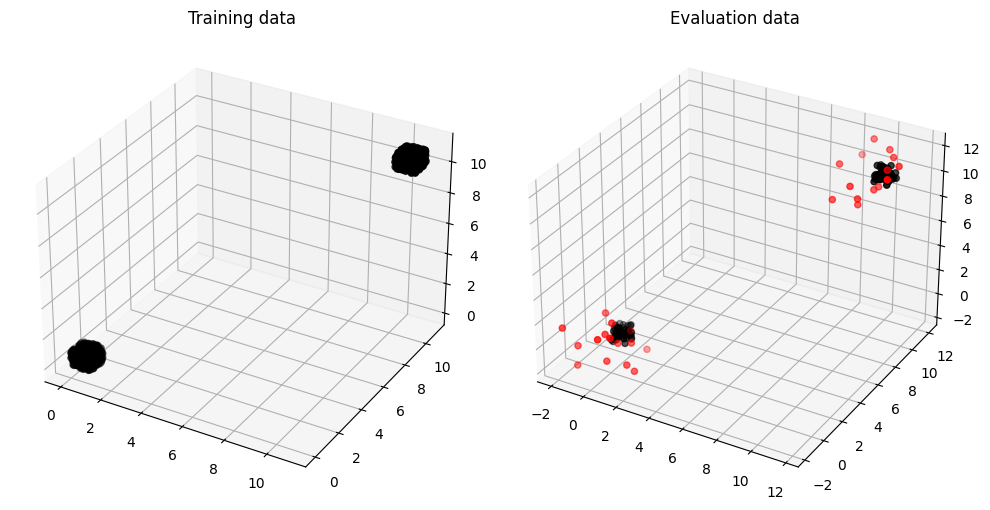

In [3]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(training[:, 0], training[:, 1], training[:, 2], c='black')
ax.set_title('Training data', loc='center')


ax = fig.add_subplot(122, projection='3d')
ax.scatter(evaluation[0:29, 0], evaluation[0:29, 1], evaluation[0:29, 2], c='red')
ax.scatter(evaluation[30:, 0], evaluation[30:, 1], evaluation[30:, 2], c='black')
ax.set_title('Evaluation data')

plt.tight_layout()

# PREPROCESSING

## Scale

In [4]:
from novelty_detection.preprocessing import minmax_scaler_given_parameters, std_scaler_given_parameters
max_val = training.max()
min_val = training.min()
mu = training.mean(0)
s = training.std(0)


train_x_norm = minmax_scaler_given_parameters(training, min_val, max_val)
test_x_norm = minmax_scaler_given_parameters(evaluation, min_val, max_val)

#train_x_norm = std_scaler_given_parameters(training, mu, s)
#test_x_norm = std_scaler_given_parameters(evaluation, mu, s)


# TRAINING

In [5]:
from novelty_detection.som import SOM

model=SOM(som_grid_size=(10,10),
          max_distance=4,
          learning_rate_0=0.5,
          max_iter=50000,
          random_state=40,
          methods={'init_som': 'uniform',
                    'bmu_distance': 'cityblock',
                    'compute_neighborhood': 'ceil',
                    'update_sigma_and_learning_rate': 'linear'})

model=model.fit(train_x_norm)
som=model.som
som_dataset=som.reshape(-1,som.shape[2])

PCA of training data (scaled) and som data

In [6]:
# 2D vizualization
pca = PCA(n_components = 2)
pca_som = pca.fit_transform(som_dataset)

# Amount of explained variance kept 2D
exp_variance_2d = pca.explained_variance_ratio_
print(f"SOM data 2D: Total = {np.sum(exp_variance_2d)} and per components = {exp_variance_2d}")

# 3D vizualization
pca_train = pca.fit_transform(train_x_norm)
exp_variance_2d = pca.explained_variance_ratio_
print(f"Train data 2D: Total = {np.sum(exp_variance_2d)} and per components = {exp_variance_2d}")

SOM data 2D: Total = 0.99919631333629 and per components = [9.98366236e-01 8.30077278e-04]
Train data 2D: Total = 0.9989816867851464 and per components = [0.99787896 0.00110273]


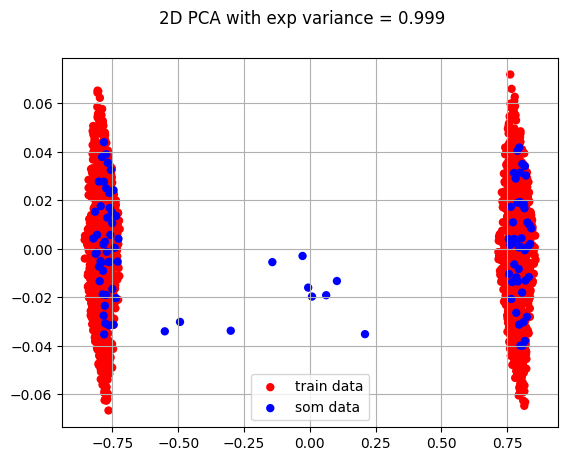

In [7]:

# Plot of the 2D PCA results
fig, ax = plt.subplots()

ax.scatter(pca_train[:,0], pca_train[:,1], color="red", label="train data", edgecolors='none')
ax.scatter(pca_som[:,0], pca_som[:,1], color="blue", label="som data", edgecolors='none')

ax.legend()
ax.grid(True)

fig.suptitle(f"2D PCA with exp variance = {round(np.sum(exp_variance_2d), 3)}")

plt.show()

PCA of test data (including its outliers) and som data

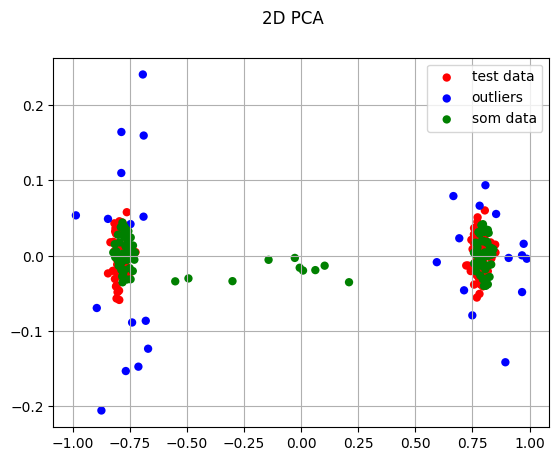

In [8]:
pca = PCA(n_components = 2)
pca_outliers = pca.fit_transform(test_x_norm[:29, :])
pca_test = pca.fit_transform(test_x_norm[30:, :])

# Plot of the 2D PCA results
fig, ax = plt.subplots()

ax.scatter(pca_test[:,0], pca_test[:,1], color="red", label="test data", edgecolors='none')
ax.scatter(pca_outliers[:,0], pca_outliers[:,1], color="blue", label="outliers", edgecolors='none')
ax.scatter(pca_som[:,0], pca_som[:,1], color="green", label="som data", edgecolors='none')

ax.legend()
ax.grid(True)

fig.suptitle("2D PCA")

plt.show()

# NOVELTY DETECTION

## Quantization error novelty detector

Compute dmax as the worst case sceneario. As it was expected, the first 30 rows of the test data have a metric of value 0. This is because the first 30 rows were imposed to be outliers

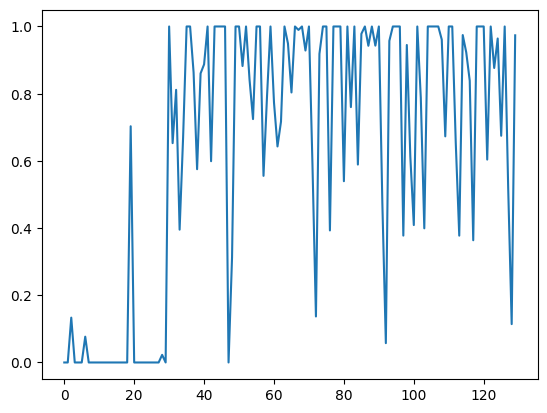

In [9]:
from novelty_detection.som_novelty_detectors import Quantization_Error
model1=Quantization_Error(som, 'worst')
metric_eq1=model1.evaluate(train_x_norm, test_x_norm)
plt.plot(np.arange(test_x_norm.shape[0]), metric_eq1)

Compute dmax as the worst case sceneario by neuron. As it was expected, the first 30 rows of the test data have a metric of value 0. This is because the first 30 rows were imposed to be outliers. With respect to the above case, this method is more restrictive, hence there are more metrics set to 0.

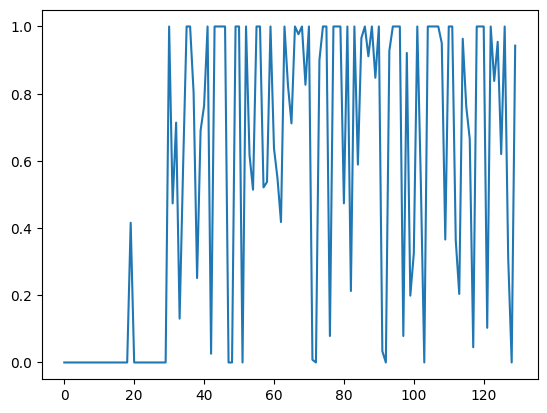

In [10]:
model2=Quantization_Error(som, 'by_bmu')
metric_eq2=model2.evaluate(train_x_norm, test_x_norm)
plt.plot(np.arange(test_x_norm.shape[0]), metric_eq2)

## Visualize distance and frequency maps

The results below correspond to the second method for computing dmax

In [12]:
import pandas as pd

dmax_map = model2.dmax_map
freq_map = model2.freq_map

df_dmax_map = pd.DataFrame(dmax_map)
df_dmax_map=(df_dmax_map
            .style
            .background_gradient(cmap='coolwarm', axis=None, vmin=0, vmax=np.nanmax(dmax_map))
            .highlight_null(color='yellow')  # Color NaNs grey
            .format(precision=3))

df_freq_map = pd.DataFrame(freq_map)
df_freq_map=(df_freq_map
            .style
            .background_gradient(cmap='coolwarm', axis=None, vmin=0, vmax=np.nanmax(freq_map))
            .highlight_null(color='yellow')  # Color NaNs grey
            .format(precision=0))

In [13]:
df_dmax_map

,0,1,2,3,4,5,6,7,8,9
0,0.029,0.028,0.025,0.023,0.027,0.024,0.032,0.022,0.022,0.029
1,0.027,0.025,0.028,0.021,0.021,0.024,0.027,0.015,0.022,0.025
2,0.023,0.030,0.020,0.021,0.024,0.020,0.030,0.018,0.023,0.027
3,0.028,0.026,0.027,0.023,0.024,0.023,0.026,0.025,0.024,0.024
4,nan,nan,nan,nan,0.019,0.026,nan,0.019,0.022,0.030
5,0.029,0.023,0.018,0.034,nan,nan,0.031,nan,nan,nan
6,0.029,0.024,0.020,0.031,0.023,0.021,0.027,0.027,0.027,0.029
7,0.030,0.025,0.026,0.019,0.026,0.030,0.027,0.023,0.023,0.022
8,0.027,0.021,0.020,0.028,0.024,0.027,0.020,0.026,0.023,0.027
9,0.026,0.028,0.024,0.024,0.022,0.023,0.022,0.026,0.023,0.029


In [14]:
df_freq_map

,0,1,2,3,4,5,6,7,8,9
0,27,21,29,23,26,25,26,25,21,28
1,20,17,20,16,24,18,22,17,18,23
2,26,15,20,17,26,25,19,23,24,30
3,35,26,24,18,23,15,25,22,17,29
4,0,0,0,0,9,28,0,16,21,21
5,29,19,20,20,0,0,32,0,0,0
6,20,19,17,23,21,16,21,33,18,35
7,31,20,19,13,18,23,24,16,18,18
8,29,21,21,20,17,18,18,14,20,23
9,25,27,22,33,19,28,15,29,25,33


## Visualize the frequency map of the rows that are detected as an anomaly

Check the corresponding neuron of the data that has been set to zero

In [19]:
def highlight_greater_than_zero(val):
    color = 'background-color: lightcoral' if val > 0 else ''
    return color

anomalies1 = test_x_norm[metric_eq1==0]
freq_map_anomalies = model2.find_bmu_counts(anomalies1, model2.som)

df_freq_map_anomalies = pd.DataFrame(freq_map_anomalies)
df_freq_map_anomalies=(df_freq_map_anomalies
            .style
            .applymap(highlight_greater_than_zero)
            .highlight_null(color='yellow')  # Color NaNs grey
            .format(precision=0))
df_freq_map_anomalies

,0,1,2,3,4,5,6,7,8,9
0,2,0,0,1,0,0,0,0,0,3
1,2,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,2
5,1,1,0,0,3,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,1,0,1,1,0,1


## Visualize test data and its associated dmin

Plot test data in blue and its associated Eq (min distance to neurons) in orange. As it can be seen, the first 30 samples (that correspond to the outliers) have a bigger min distance to the som neurons, while the rest of the data (which is similar the training data) has a much lower min distnace and its values are more consistent (they aren't as disperse).

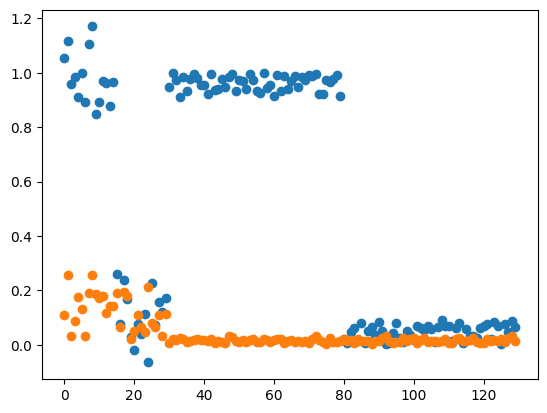

In [18]:
plt.scatter(np.arange(test_x_norm.shape[0]), test_x_norm[:,0])
plt.scatter(np.arange(test_x_norm.shape[0]), model1.find_dmin(test_x_norm, model1.som))

## Visualize the detected anomalies

We'll create two plots, one plot showing the true anomalies in red and one plot showing the detected anomalies in green. Results are computed using metric 1

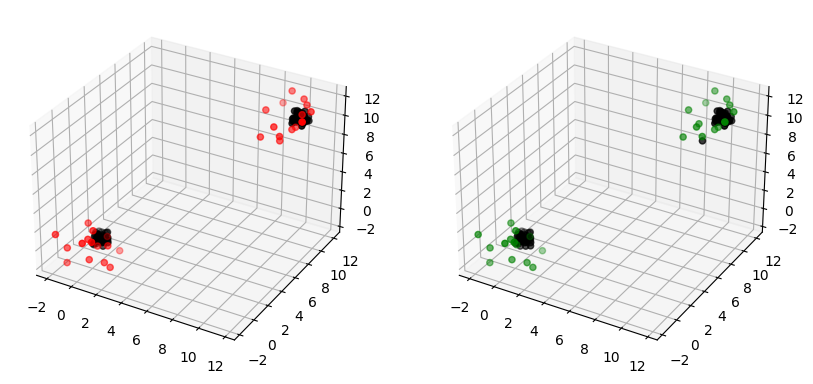

In [20]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(evaluation[0:29, 0], evaluation[0:29, 1], evaluation[0:29, 2], c='red')
ax.scatter(evaluation[30:, 0], evaluation[30:, 1], evaluation[30:, 2], c='black')

sec = fig.add_subplot(122, sharex=ax, sharey=ax, projection='3d')
selector = metric_eq1 == 0
sec.scatter(evaluation[selector, 0], evaluation[selector, 1], evaluation[selector, 2], c='green')
sec.scatter(evaluation[~selector, 0], evaluation[~selector, 1], evaluation[~selector, 2], c='black')

Check if all the predictions are correct

In [44]:
real_outliers = evaluation[0:29, :]
detected_outliers = evaluation[selector, :]

# here we are checking for identical rows of detected_outliers with respect to real_outliers
res = (detected_outliers[:, None] == real_outliers).all(-1).any(-1)
_, counts = np.unique(res, return_counts=True)
accuracy = counts[1] / (counts[0] + counts[1])
accuracy

0.9259259259259259